# Contenu d'image

**IMPORTANT** : Créez une ressource *Vision par ordinateur* ou *Computer vision* et renseignez `SERVEUR` avec votre point de terminaison (endpoint). Récupérez également la clé et renseignez là lors de l'exécution de la première cellule.

In [1]:
from getpass import getpass

CLE = getpass("Clé")
SERVEUR = 'https://vision00.cognitiveservices.azure.com/' # Votre point de terminaison
URL = 'https://raw.githubusercontent.com/LinkedInLearning/azure-ai-3268143/02_03/src/data'

In [2]:
import requests
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import patches

def rectangle(img, rect, texte, couleur='r'):
  x, y, l, h = [rect[k] for k in 'xywh']
  img.axes.add_patch(patches.Rectangle(
      (x, y), l, h, fill=False, linewidth=2, color=couleur
  ))
  plt.text(x, y, texte, fontsize=15, weight="bold", va="bottom")

def analyser(fichier):
  reponse = requests.post(
    url=f'{SERVEUR}/vision/v2.0/analyze',
    headers={
      'Ocp-Apim-Subscription-Key': CLE,
      'content-type': 'application/json'
    },
    params={
      'visualFeatures': 'Adult,Brands,Categories,Color,Description,ImageType,Objects,Tags'
    },
    data="{'url': '%s/%s'}" % (URL, fichier)
  )
  resultat = reponse.json()
  print("%s (%d%%) - Adulte (%d%%/%d%%)" % (
    resultat['description']['captions'][0]['text'].upper(),
    100*resultat['description']['captions'][0]['confidence'],
    100*resultat['adult']['adultScore'],
    100*resultat['adult']['racyScore']
  ))
  plt.figure(figsize=(10, 10))
  img = plt.imshow(mpimg.imread(f'data/{fichier}'), alpha=0.6)
  for obj in resultat['objects']:
    rectangle(img, obj['rectangle'], "%s (%d%%)" %
              (obj['object'], obj['confidence']*100))
  for obj in resultat['brands']:
    rectangle(img, obj['rectangle'], "%s (%d%%)" %
              (obj['name'], obj['confidence']*100), 'b')
  y = 0
  for tag in resultat['tags']:
    taille = int(25*tag['confidence'])
    plt.text(resultat['metadata']['width']+10, y, tag['name'].capitalize(),
             fontsize=taille, weight='normal', va='top', ha='left')
    y += taille*2
    if y > resultat['metadata']['height']:
        break
  plt.axis("off")


A PLATE OF FOOD ON A TABLE (98%) - Adulte (0%/0%)


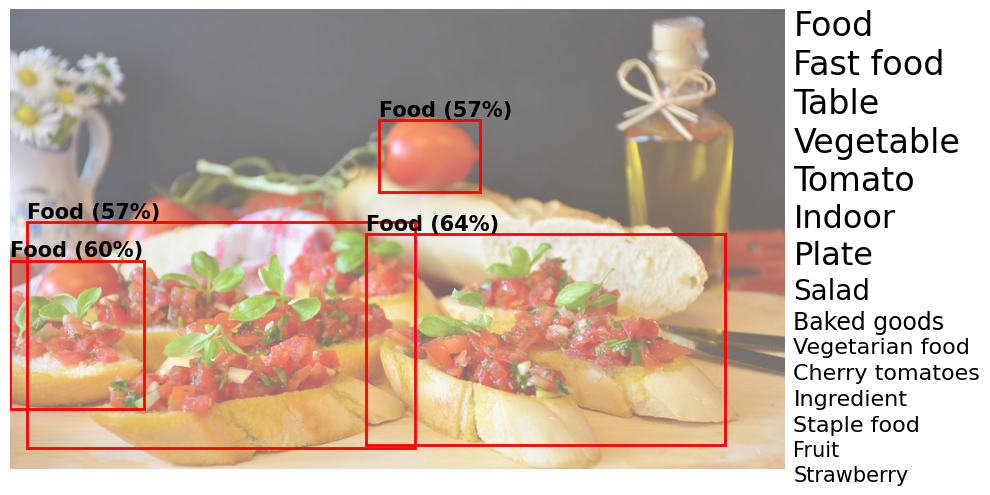

In [12]:
analyser('img0.jpg')

A CAT SITTING ON A TREE BRANCH (91%) - Adulte (0%/0%)


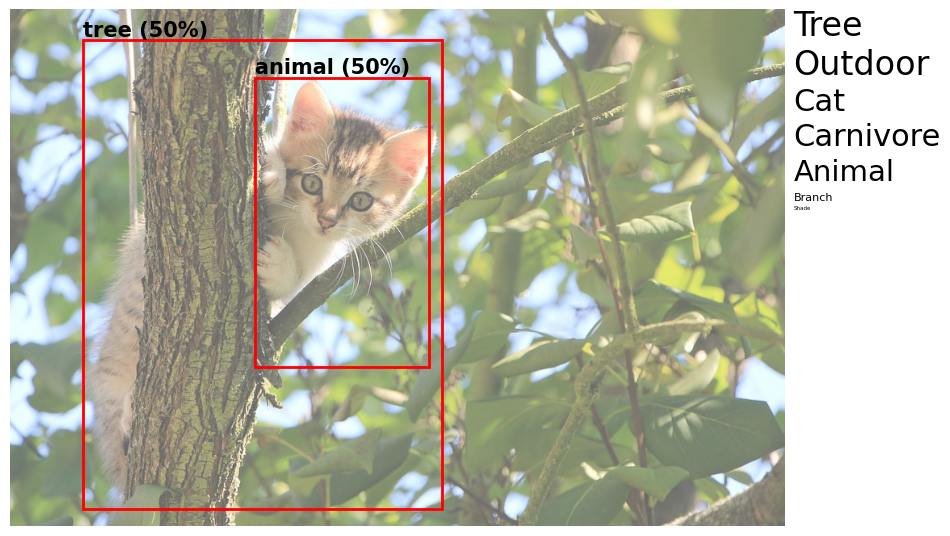

In [4]:
analyser('img1.jpg')

A DARK ROOM (69%) - Adulte (4%/7%)


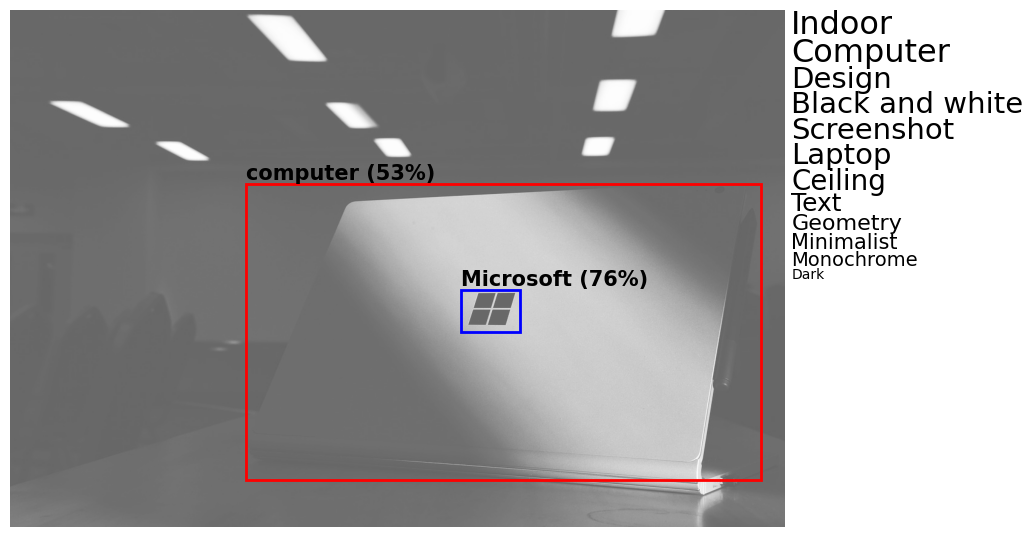

In [5]:
analyser('img2.jpg')

A PERSON SITTING ON A BED (32%) - Adulte (94%/96%)


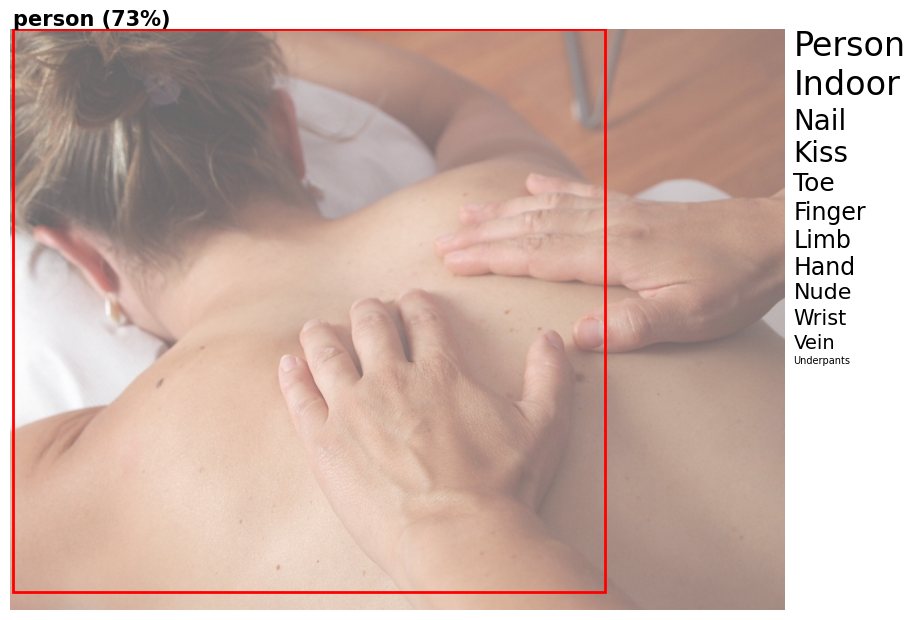

In [6]:
analyser('img3.jpg')

DIAGRAM, ENGINEERING DRAWING (99%) - Adulte (0%/0%)


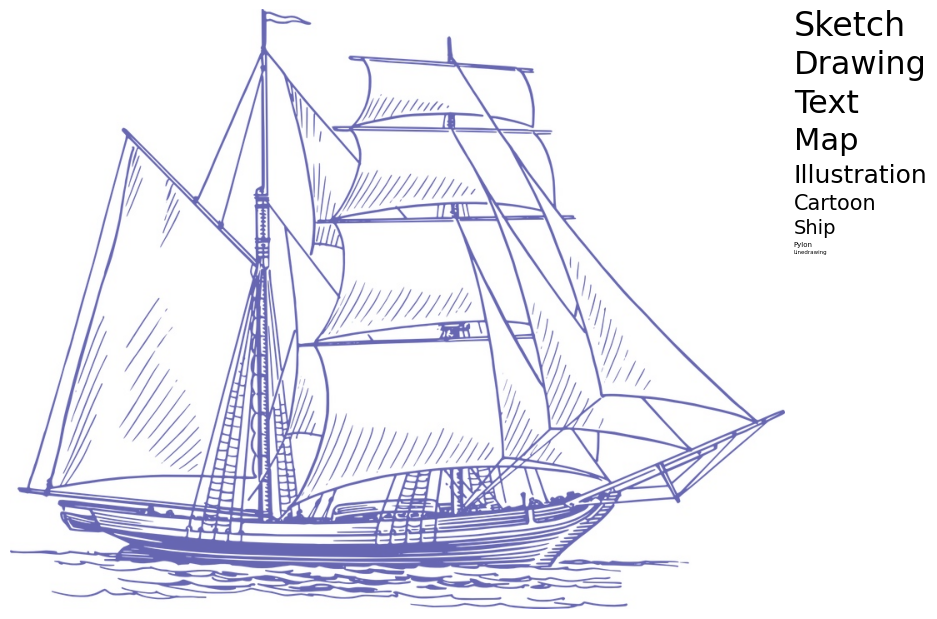

In [7]:
analyser('img4.jpg')

A MAN RIDING A SNOWBOARD DOWN A SNOW COVERED SLOPE (82%) - Adulte (3%/5%)


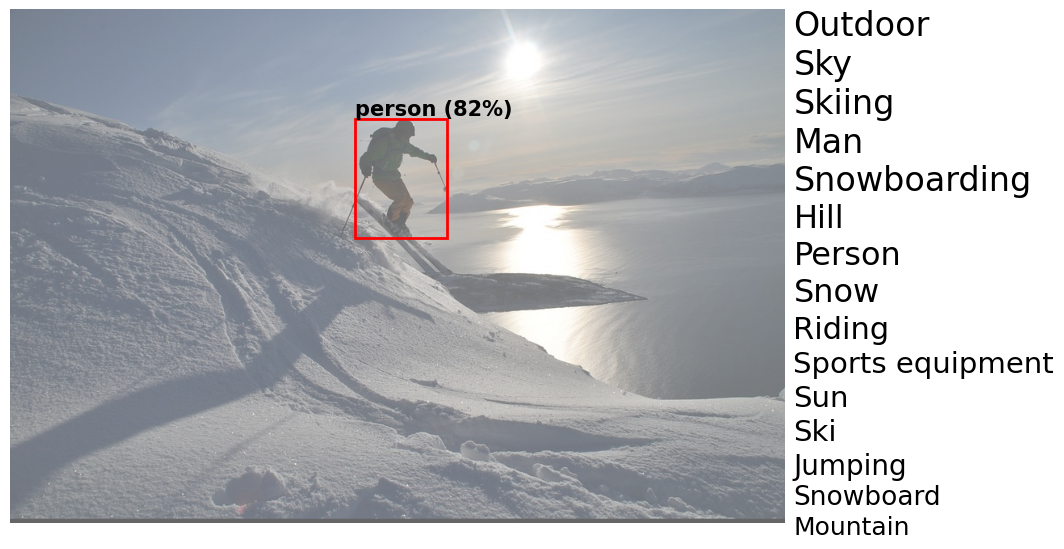

In [8]:
analyser('img5.jpg')